# Testing setBLP.jl

## Packages

In [1]:
import LinearAlgebra ,Base

In [2]:
using Plots

## Structures and related functions

#### Vertex

In [3]:
mutable struct Vertex
    v::Vector{Real}
end

In [4]:
function subVertex(v1::Vertex,v2::Vertex)
    return  Vertex(v1.v-v2.v)
end

Base.:(-)(v1::Vertex,v2::Vertex) = Vertex(v1.v-v2.v)

function addVertex(v1::Vertex,v2::Vertex)
    return Vertex(v1.v+v2.v)
end

Base.:(+)(v1::Vertex,v2::Vertex) = Vertex(v1.v+v2.v)

In [5]:
function lambdaVertex(λ::Real,ver::Vertex)
    return Vertex(λ*ver.v)
end

Base.:(*)(λ::Real,ver::Vertex) = lambdaVertex(λ,ver)

In [6]:
function negVertex(ver::Vertex)
    return Vertex(-ver.v)
end

Base.:(-)(ver::Vertex) = negVertex(ver)

In [7]:
function dot(v1::Vertex,v2::Vertex)
    return LinearAlgebra.dot(v1.v,v2.v)
end

function norm(ver::Vertex)
    return LinearAlgebra.norm(ver.v)
end

LinearAlgebra.:(*)(v1::Vertex,v2::Vertex) = dot(v1::Vertex,v2::Vertex)

In [8]:
function xangle(p1::Vertex,p2::Vertex)
    Δ = (p2-p1).v
    flag=false
    if Δ[2] < 0
        Δ[2] = -Δ[2]
        flag = true
    end
    xang =atan(Δ[2],abs(Δ[1]))
    if Δ[1]<0
        xang = pi-xang
    end
    if flag
        xang=2*pi-xang
    end
    return xang

end

xangle (generic function with 1 method)

In [9]:
function fetchY(ver::Vertex)
    return ver.v[2]
end

function fetchX(ver::Vertex)
    return ver.v[1]
end

fetchX (generic function with 1 method)

#### Segment

In [10]:
mutable struct Segment
    p1::Vertex
    p2::Vertex
    checkInput::Function
    length::Function
    dim::Function

    
    function Segment(p1,p2)
        this = new()

        this.p1 = p1
        this.p2 = p2

        this.checkInput = function()
            return size(this.p1.v) == size(this.p2.v)       
        end

        this.length = function()
            return norm(this.p1-this.p2)
        end

        this.dim = function()
            if this.checkInput()
                return length(this.p1.v)
            else
                return false
            end
        end

        return this        
    end
end


In [11]:
function dotDist(p::Vector{<:Real}, segment::Segment) 
    if segment.checkInput()
        if length(p) == segment.dim()
            p1_p2 = segment.p1 -segment.p2
            p_p2 = p -segment.p2

            λ = LinearAlgebra.dot(p1_p2,p_p2)/LinearAlgebra.dot(p1_p2,p1_p2)
            λ = max(min(λ,1),0)

            p0 = λ*segment.p1 + (1-λ)*segment.p2 

            return LinearAlgebra.norm(p-p0)
        else
            return "dimention of p doesnt match dimention of segment"
        end
    else
        return "Segment has wrong dimentions"
    end
end

function dotDist(p::Vertex, segment::Segment) 
    if segment.checkInput()
        if length(p.v) == segment.dim()
            p1_p2 = segment.p1 -segment.p2
            p_p2 = p -segment.p2

            λ = LinearAlgebra.dot(p1_p2.v,p_p2.v)/LinearAlgebra.dot(p1_p2.v,p1_p2.v)
            λ = max(min(λ,1),0)

            p0 = λ*segment.p1 + (1-λ)*segment.p2 

            return LinearAlgebra.norm((p-p0).v)
        else
            return "dimention of p doesnt match dimention of segment"
        end
    else
        return "Segment has wrong dimentions"
    end
end

dotDist (generic function with 2 methods)

In [12]:
function xangle(seg::Segment)
    Δ = seg.p2-seg.p1
    flag=false
    if Δ[2] < 0
        Δ[2] = -Δ[2]
        flag = true
    end
    xang =atan(Δ[2],abs(Δ[1]))
    if Δ[1]<0
        xang = pi-xang
    end
    if flag
        xang=2*pi-xang
    end
    return xang

end

xangle (generic function with 2 methods)

#### Polygon

In [13]:
mutable struct Polygon
    vertices :: Vector{Vertex}
    sort :: Function
    plot :: Function
    angles :: Function
    scatter :: Function

    function Polygon(vertices)
        this = new()

        this.vertices=vertices
        this.sort = function()
            n=length(this.vertices)
            #step 1: find the point with a minimal y coordinate and put it first.
            # comment: sorting is complexity nlog(n) but the following is just n
            #using sorting:
            #I = sortperm(fetchY.(this.vertices))
            #this.vertices = this.vertices[I]
            #going over the list
            m=fetchY(this.vertices[1])
            for i=2:n
                l=fetchY(this.vertices[i])
                if l<m #then swap
                    m=l
                    temp=this.vertices[i]
                    this.vertices[i]=this.vertices[1]
                    this.vertices[1]=temp
                end
            end
            #step 2: compute angles between the minimal vertex and all other vertices
            angs =zeros(n) #first column for angles and second column for the x coordinate
            angs[1]=-1
            v1 =this.vertices[1]
            for i=2:n
                angs[i] = xangle(v1,this.vertices[i])
            end
            #step 3: sort by angle
            I=sortperm(angs)
            this.vertices=this.vertices[I]   
        end
        this.angles = function()
            n=length(this.vertices)
            ang=zeros(n)
            for i=1:n
                i==n ? j=1 : j=i+1
                ang[i] =xangle(this.vertices[i],this.vertices[j])                
            end
            return ang
        end
        
        this.plot = function()
            n=length(this.vertices)
            x=zeros(n+1); y=zeros(n+1);
            for i=1:n
                x[i]=this.vertices[i].v[1]
                y[i]=this.vertices[i].v[2]
            end
            x[n+1]=this.vertices[1].v[1]
            y[n+1]=this.vertices[1].v[2]
            plot(x,y,label="",fill=true)
        end
        
        this.scatter = function()
            n=length(this.vertices)
            x=zeros(n); y=zeros(n);
            for i=1:n
                x[i]=this.vertices[i].v[1]
                y[i]=this.vertices[i].v[2]
            end
            scatter(x,y,label="")
        end
            
        return this
    end
end

In [14]:
function minkowskiSum(v::Vertex,P::Polygon)
    # this function adds v to every vertex of P
    n=length(P.vertices)
    R=P #initial value
    for i=1:n
        R.vertices[i] +=v
    end
    return R
end

function minkowskiSum(P::Polygon,v::Vertex)
    # this function adds v to every vertex of P
    n=length(P.vertices)
    R=P #initial value
    for i=1:n
        R.vertices[i] +=v
    end
    return R
end
    
Base.:(+)(v::Vertex,P::Polygon) = minkowskiSum(v,P)
Base.:(+)(P::Polygon,v::Vertex) = minkowskiSum(P,v)

In [15]:
function minkowskiSum(P::Polygon,Q::Polygon)
    # Computes the minkowski sum of two convex polygons: P and Q. The polygons
    # are represented by their vertices and are ordered counter clockwise such
    #* that the first vertex will be the one who has the smallest Y coordinate
    # (and smallest X coordinate in case of a tie).  This assumption is maintained
    # in twoDproj by conditions in BLPcalculator.
    
    m = length(P.vertices)
    n = length(Q.vertices)
    
# case 1: Both P and Q are length 1 (vertices)
    if m==1 && n==1 
        R = Polygon([P.vertices[1]+Q.vertices[1]])

# case 2: P is length 1 (a vertex) and Q is not    
    elseif m==1    
        R = P.vertices[1] + Q

# case 3: Q is length 1 (a vertex) and P is not
    elseif n==1
        R = Q.vertices[1] + P
    
# case 4: both Q and P have more than 1 vertex
    else
        angP=[P.angles(); 100]
        angQ=[Q.angles(); 100]
    
    #m = length(angP)
    #n = length(angQ)
    
        PP = [P.vertices; P.vertices[1]]
        QQ = [Q.vertices; Q.vertices[1]]
    
        println("m=",m," n=",n)
    
        println("angP= ", angP)
        println("angQ= ", angQ)
    
        i=1; j=1;
        println("----- begin ----------")
    
        R =Polygon([PP[1]+QQ[1]]) # a polygon with the sum of the two lower points as the first vertex.
        println("R vertices: ",R.vertices)
        while (i<m+1 || j<n+1)
            if angP[i]<angQ[j] 
                println("angP[i] is minimal")
                i +=1
            elseif angQ[j]<angP[i]
                println("angQ[j] is minimal")
                j +=1
            else
                i +=1
                j +=1
            end
            R.vertices = [ R.vertices; PP[i]+QQ[j]]
            println(i,j)
            println("R vertices: ",R.vertices)
        end
    end
    return R
end

Base.:(+)(P::Polygon,Q::Polygon) = minkowskiSum(P,Q)

In [16]:
function lambdaPolygon(λ::Real,P::Polygon)
    n = length(P.vertices)
    R=P
    for i=1:n
       R.vertices[i]=λ*P.vertices[i] 
    end
end

#question: can this function be written using a map() function?

lambdaPolygon (generic function with 1 method)

# Testing

Devining a bunch of vertices:

In [17]:
v4=Vertex([0,0.4]);
v2=Vertex([-1.1,0]);
v3=Vertex([1.1,0]);
v1=Vertex([0.0,-0.6]);
v5=Vertex([0.5,0.3]);

u4=Vertex([-1,0]);
u2=Vertex([1,0.1]);
u3=Vertex([-1,0.55]);
u1=Vertex([1.1,0.5]);
u5=Vertex([0.1,1.1]);

## Testing functions on vertices

In [18]:
# summation:
# v1 = [0.0,-0.6]
# v5 = [0.5,0.3]

v1+v5

Vertex(Real[0.5, -0.3])

In [19]:
#testing lambdaVertex()
# v5 = [0.5,0.3]

2*v5

Vertex(Real[1.0, 0.6])

In [20]:
#testing negVertex()
# v3 = [1.1,0]

-v3

Vertex(Real[-1.1, -0.0])

In [21]:
# dot product of two vertices

v1*v5

-0.18

In [22]:
# norm of a vertex

norm(u3)

1.1412712210513327

## Testing functions on segments

In [23]:
# distance

seg = Segment(v1,v5)
dotDist(u1,seg)

0.632455532033676

## Testing functions on Polygons

In [24]:
P = Polygon([v1,v2,v3,v4])

Polygon(Vertex[Vertex(Real[0.0, -0.6]), Vertex(Real[-1.1, 0.0]), Vertex(Real[1.1, 0.0]), Vertex(Real[0.0, 0.4])], var"#7#11"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#9#13"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#8#12"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#10#14"{Polygon}(Polygon(#= circular reference @-2 =#)))

In [25]:
# What is this "circular reference" comment above???

In [26]:
# Testing sort() and angles()

#Before
println("Before:")
println(P.vertices)
println(P.angles())

#After
P.sort();
println("After:")
println(P.vertices)
println(P.angles())


Before:
Vertex[Vertex(Real[0.0, -0.6]), Vertex(Real[-1.1, 0.0]), Vertex(Real[1.1, 0.0]), Vertex(Real[0.0, 0.4])]
[2.642245931909663, 0.0, 2.792821650005886, 4.71238898038469]
After:
Vertex[Vertex(Real[0.0, -0.6]), Vertex(Real[1.1, 0.0]), Vertex(Real[0.0, 0.4]), Vertex(Real[-1.1, 0.0])]
[0.49934672168013006, 2.792821650005886, 3.4903636571737002, 5.783838585499456]


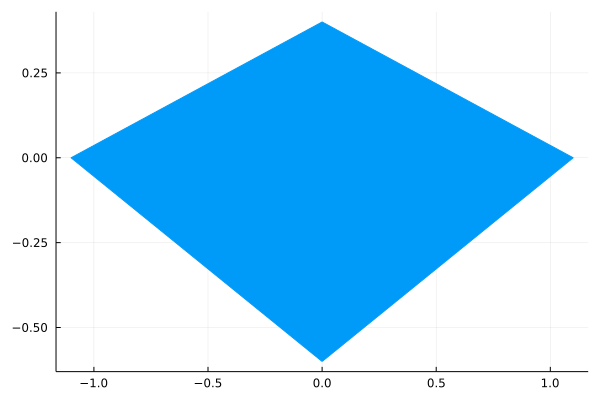

In [27]:
# Testing plot()

P.plot()

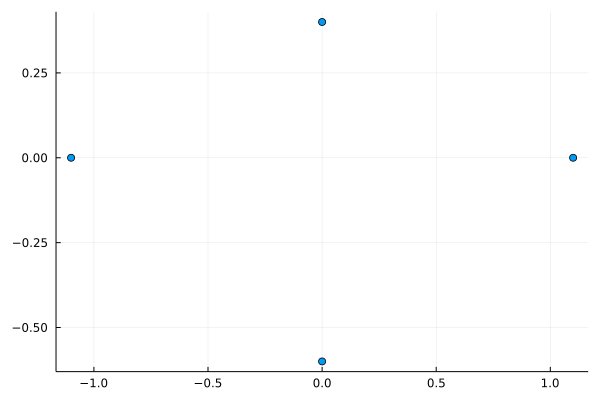

In [28]:
# Testing scatter()

P.scatter()

### Testing Minkowski Summation

In [29]:
# n=1 and m=1

P=Polygon([v1])
Q=Polygon([u1])

R = P+Q
println(R.vertices)

Vertex[Vertex(Real[1.1, -0.09999999999999998])]


In [30]:
#n=1 m>1

P=Polygon([v1])
Q=Polygon([u1,u2])
Q.sort()

R = P+Q
println(R.vertices)

Vertex[Vertex(Real[1.0, -0.5]), Vertex(Real[1.1, -0.09999999999999998])]


In [31]:
# n>1 m=1

P=Polygon([v1,v2])
Q=Polygon([u1])
P.sort()

R = P+Q
println(R.vertices)

Vertex[Vertex(Real[1.1, -0.09999999999999998]), Vertex(Real[0.0, 0.5])]


In [32]:
# n>1 m>1

P=Polygon([v1,v2,v3,v4,v5])
Q = Polygon([u1,u2,u3,u4,u5])

P.sort()
Q.sort()

R = P+Q
println(R.vertices)

m=5 n=5
angP= [0.49934672168013006, 2.677945044588987, 2.9441970937399122, 3.4903636571737002, 5.783838585499456, 100.0]
angQ= [0.049958395721942765, 1.3258176636680323, 2.601173153319209, 3.6052402625905993, 4.71238898038469, 100.0]
----- begin ----------
R vertices: Vertex[Vertex(Real[-1.0, -0.6])]
angQ[j] is minimal
12
R vertices: Vertex[Vertex(Real[-1.0, -0.6]), Vertex(Real[1.0, -0.5])]
angP[i] is minimal
22
R vertices: Vertex[Vertex(Real[-1.0, -0.6]), Vertex(Real[1.0, -0.5]), Vertex(Real[2.1, 0.1])]
angQ[j] is minimal
23
R vertices: Vertex[Vertex(Real[-1.0, -0.6]), Vertex(Real[1.0, -0.5]), Vertex(Real[2.1, 0.1]), Vertex(Real[2.2, 0.5])]
angQ[j] is minimal
24
R vertices: Vertex[Vertex(Real[-1.0, -0.6]), Vertex(Real[1.0, -0.5]), Vertex(Real[2.1, 0.1]), Vertex(Real[2.2, 0.5]), Vertex(Real[1.2000000000000002, 1.1])]
angP[i] is minimal
34
R vertices: Vertex[Vertex(Real[-1.0, -0.6]), Vertex(Real[1.0, -0.5]), Vertex(Real[2.1, 0.1]), Vertex(Real[2.2, 0.5]), Vertex(Real[1.2000000000000002,

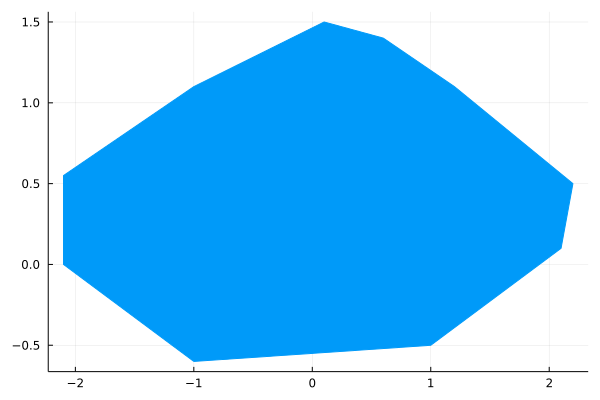

In [33]:
R.sort();
R.plot()

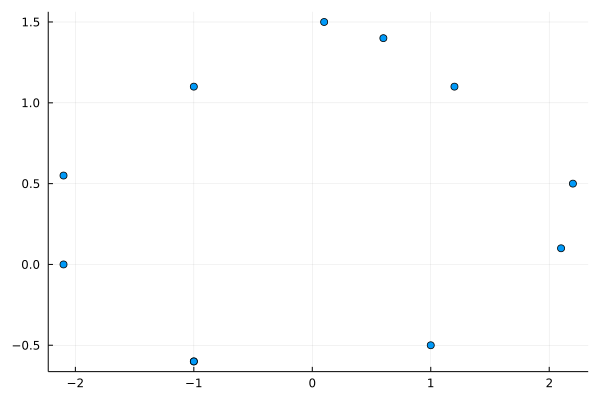

In [34]:
R.scatter()

In [35]:
R.angles()

11-element Vector{Float64}:
 0.0
 0.04995839572194275
 0.49934672168013006
 1.3258176636680323
 2.601173153319209
 2.677945044588987
 2.9441970937399127
 3.4903636571737
 3.6052402625905993
 4.71238898038469
 5.783838585499456

In [36]:
R.vertices

11-element Vector{Vertex}:
 Vertex(Real[-1.0, -0.6])
 Vertex(Real[-1.0, -0.6])
 Vertex(Real[1.0, -0.5])
 Vertex(Real[2.1, 0.1])
 Vertex(Real[2.2, 0.5])
 Vertex(Real[1.2000000000000002, 1.1])
 Vertex(Real[0.6, 1.4000000000000001])
 Vertex(Real[0.1, 1.5])
 Vertex(Real[-1.0, 1.1])
 Vertex(Real[-2.1, 0.55])
 Vertex(Real[-2.1, 0.0])

In [37]:
length(R.vertices)

11